In [1]:
import requests
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [10]:
import wandb
wandb.init(project="blip-2-adversaial-training", entity="capstone-project")

In [4]:
# ! pip install transformers
# ! pip install torchvision
# ! pip install wandb

In [2]:
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration
device = "cuda" if torch.cuda.is_available() else "cpu"


MODEL_ID = "Salesforce/blip2-opt-2.7b"
processor = AutoProcessor.from_pretrained(MODEL_ID)

In [28]:
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
# model = Blip2ForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=torch.float16)
model = Blip2ForConditionalGeneration.from_pretrained(MODEL_ID)
model.to(device)

In [29]:
from transformers import BridgeTowerProcessor, BridgeTowerForMaskedLM

processor2 = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-large-itm-mlm")
model2 = BridgeTowerForMaskedLM.from_pretrained("BridgeTower/bridgetower-large-itm-mlm")
model2.to(device)

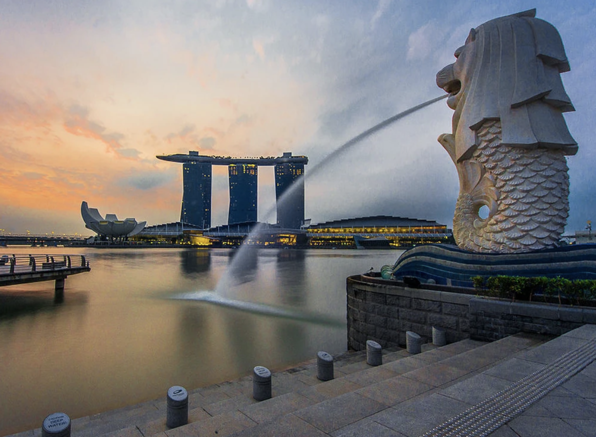

In [30]:
url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png'
input_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
# input_img = torch.tensor(np.array(input_img) / 255.0, dtype=torch.float32, requires_grad=True)
display(input_img.resize((596, 437)))
input_img = torch.tensor(np.array(input_img) / 255.0)

In [31]:
def get_input_optimizer(input_img, learning_rate):
    # this line to show that input is a parameter that requires a gradient
    # optimizer = torch.optim.Adam([input_img], lr=learning_rate)
    optimizer = torch.optim.Adam([input_img], lr=learning_rate)
    return optimizer

In [32]:
# We also put the model in evaluation mode, so that specific layers
# such as dropout or batch normalization layers behave correctly.
model.eval()
model.requires_grad_(False)

model2.eval()
model2.requires_grad_(False)

learning_rate = 0.01

# Text prompt
prompt = "Question: name one object in the image? Answer:"
target_word_index = 13599

In [33]:
text = "a <mask> looking out of the window"
target_word_index2 = 3428

In [34]:
input_img.size()

torch.Size([874, 1192, 3])

In [35]:
# inputs = processor(input_img, text=prompt, return_tensors="pt").to(device, torch.float16)
inputs = processor(input_img, text=prompt, return_tensors="pt").to(device)

In [36]:
inputs2 = processor2(input_img, text, return_tensors="pt").to(device)

In [37]:
inputs['pixel_values'].size()

torch.Size([1, 3, 224, 224])

In [38]:
inputs2['pixel_values'].size()

torch.Size([1, 3, 294, 294])

In [39]:
# inputs['pixel_values'].requires_grad=True
inputs['pixel_values'].requires_grad_(False)
inputs2['pixel_values'].requires_grad_(False)

tensor([[[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          ...,
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],

         [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          ...,
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521]],

         [[-1.4802, -1.4802, -1.4802,  ..., -1.4802, -1.4802, -1.4802],
          [-1.4802, -1.4802, -

In [40]:
change = torch.zeros_like(inputs2['pixel_values']).to(device)
change.requires_grad = True

In [41]:
change.size()

torch.Size([1, 3, 294, 294])

In [42]:
# optimizer = get_input_optimizer(inputs['pixel_values'], learning_rate)
optimizer = get_input_optimizer(change, learning_rate)

In [43]:
inputs['pixel_values'].max()

tensor(-1.4683, device='cuda:0')

In [44]:
deep_copy_tensor = inputs['pixel_values'].clone()
deep_copy_tensor2 = inputs2['pixel_values'].clone()

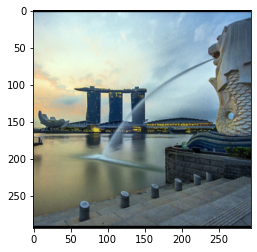

In [45]:
# optimized_image = inputs['pixel_values'].detach().cpu().numpy()
optimized_image = (inputs2['pixel_values'] + change).detach().cpu().numpy()

# Scale each channel independently between 0 and 1
min_vals = optimized_image.min(axis=(2, 3), keepdims=True)
max_vals = optimized_image.max(axis=(2, 3), keepdims=True)
scaled_image = (optimized_image - min_vals) / (max_vals - min_vals)

# Plot the scaled image
plt.imshow(scaled_image.squeeze().transpose(1, 2, 0))
plt.show()

In [46]:
losses = []
torch.autograd.set_detect_anomaly(True)

In [47]:
delta = 0.3

In [57]:
deltas = [0.3, 0.16, 0.03]

In [58]:
my_dict = {}

for delta in deltas:
    with torch.no_grad():
            change[:] = 0.0
    print('Optimizing..')
    run = [0]
    losses = []
    while True:

        inputs['pixel_values'] = deep_copy_tensor + change[:,:,:224,:224]
        inputs2['pixel_values'] = deep_copy_tensor2 + change

        optimizer.zero_grad()

        outputs = model(**inputs)
        outputs2 = model2(**inputs2)

        # Apply softmax to the logits
        logits = outputs.logits[0, 1:2, :]
        logits2 = outputs2.logits[0, 2:3, :]

        probabilities = torch.softmax(logits, dim=1)
        probabilities2 = torch.softmax(logits2, dim=1)

        target_prob = probabilities[0, target_word_index]
        target_prob2 = probabilities2[0, target_word_index2]

        loss = -torch.log(target_prob)
        loss += -torch.log(target_prob2)

        print('loss', loss)

        losses.append(loss.item())

        if loss.item()<0.1:
            break

        loss.backward()

        run[0] += 1

        optimizer.step()

        with torch.no_grad():
            change[:] = change.clamp(-delta, delta)
    
    my_dict[str(delta)] = losses.copy()

            
            
import csv

# Get the maximum length of all lists
max_length = max(len(lst) for lst in my_dict.values())

# Fill missing values with a placeholder (e.g., None)
for key, value in my_dict.items():
    my_dict[key] += [0] * (max_length - len(value))

# Writing to CSV
csv_file_path = 'loss_vs_delta.csv'

with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Write header (keys of the dictionary)
    csv_writer.writerow(my_dict.keys())

    # Write rows (values of the dictionary)
    csv_writer.writerows(zip(*my_dict.values()))

print(f"CSV file saved to {csv_file_path}")


Optimizing..
loss tensor(20.9887, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(22.0781, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(21.8983, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(22.9963, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(21.2065, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(19.9779, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(19.4624, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(17.8713, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(17.3832, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(16.3825, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(15.4412, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(14.4140, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(14.2897, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(14.0895, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.9640, device='cuda:0', grad_fn=<AddBackward0>)
loss tensor(13.8698, device='cuda:0', grad_fn=<AddBackwar

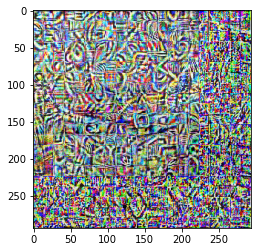

In [59]:
optimized_image = (deep_copy_tensor2 + change).detach().cpu().numpy()

# Scale each channel independently between 0 and 1
min_vals = optimized_image.min(axis=(2, 3), keepdims=True)
max_vals = optimized_image.max(axis=(2, 3), keepdims=True)
scaled_image = (optimized_image - min_vals) / (max_vals - min_vals)

# Plot the scaled image
plt.imshow(scaled_image.squeeze().transpose(1, 2, 0))
plt.show()

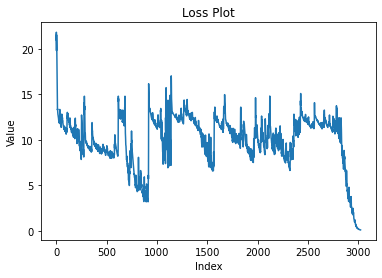

In [68]:
losses_array = [loss.detach().cpu().numpy() for loss in losses]

# Plot the array
plt.plot(np.array(losses_array))

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Loss Plot')

# Show the plot
plt.show()

In [61]:
outputs = model(**inputs)
logits = outputs.logits[0, 1:2, :]
# print('is logits nan', torch.isnan(logits).any())
# print(logits.size())
probabilities = torch.softmax(logits, dim=1)

# Assuming target_word_index is a scalar
target_prob = probabilities[0, target_word_index]

print(target_prob)

tensor(0.9065, device='cuda:0', grad_fn=<SelectBackward0>)


In [62]:
torch.argmax(probabilities, dim=1)

tensor([13599], device='cuda:0')

In [69]:
inputs['pixel_values'] = deep_copy_tensor + change[:, :, :224, :224]

In [70]:
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

/n/home09/nnayak/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 the black and white striped shirt



In [71]:
processor.batch_decode(torch.tensor([13599]), skip_special_tokens=True)

['chair']